# Climate stripes demonstrated in a notebook

In [ ]:
!pip install -r requirements.txt

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import fsspec
from convertbng.util import convert_bng

RAL_LAT, RAL_LON = 51.570664384, -1.308832098

fpath = index_uri = "haduk-grid1.json"


def check_location_is_near(lat, lon, point_ds, ds, threshold=0.05):
    """
    Checks that selected eastings and northings (in BNG coordinates) are within the lat/lon threshold of
    the `lat` and `lon` requested by the user.

    Raises an exception if outside the acceptable threshold.

    Returns tuple of: (eastings, northings)
    """
    y = float(point_ds.projection_y_coordinate.values)
    x = float(point_ds.projection_x_coordinate.values)
    
    lat_diff = abs(float(ds.latitude.sel(projection_y_coordinate=y, projection_x_coordinate=x)) - lat)
    lon_diff = abs(float(ds.longitude.sel(projection_y_coordinate=y, projection_x_coordinate=x)) - lon)

    assert lat_diff < threshold, f"Lat diff is too big: {lat_diff}"
    assert lon_diff < threshold, f"Lon diff is too big: {lon_diff}"

    return (x, y)


def extract_time_series_at_location(lat=RAL_LAT, lon=RAL_LON, ref_period=(1901, 2000)):
    ref_period = tuple([str(dt) for dt in ref_period])
    compression = "zstd" if index_uri.split(".")[-1].startswith("zst") else None
    mapper = fsspec.get_mapper("reference://", fo=index_uri, target_options={"compression": compression})

    print("opening kerchunk...need bigger arrays and specify duplicate coords and lat lon from each")
    ds = xr.open_zarr(mapper, consolidated=False, use_cftime=True, decode_timedelta=False)

    print("convert to northings, eastings...")
    requested_eastings, requested_northings = [i[0] for i in convert_bng(lon, lat)] 
             #lat_lon_to_eastings_northings(lon, lat)
 
    print("extract nearest grid point...")
    temp_series = ds.tas.sel(projection_y_coordinate=requested_northings, projection_x_coordinate=requested_eastings, method="nearest")

    # Check the chosen location is near the requested location
    actual_eastings, actual_northings = check_location_is_near(lat, lon, temp_series, ds)

    # Get mean over reference period
    reference_mean = temp_series.sel(time=slice(*ref_period)).mean()

    # Construct content to return
    response = {
        "temp_series": temp_series.squeeze(),
        "demeaned_temp_series": (temp_series - reference_mean).squeeze(),
        "eastings": actual_eastings, "northings": actual_northings,
        "lat": float(ds.latitude.sel(projection_y_coordinate=actual_northings, projection_x_coordinate=actual_eastings)),
        "lon": float(ds.longitude.sel(projection_y_coordinate=actual_northings, projection_x_coordinate=actual_eastings))
    }
    print("Returning data objects...")
    return response

opening kerchunk...need bigger arrays and specify duplicate coords and lat lon from each
convert to northings, eastings...
extract nearest grid point...
Returning data objects...
Downloaded data...
Starting plot


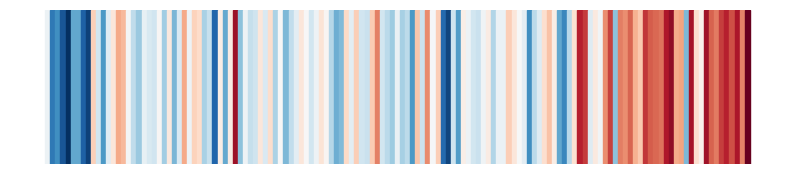

In [176]:
def rgba_to_hex(r, g, b, a=None):
    r, g, b = [int(i * 255) for i in (r, g, b)]
    return "#" + "".join([("0" + hex(i).split("x")[1])[-2:] for i in (r, g, b)])


def plot_climate_stripes_uk_location(lat, lon):
    resp = extract_time_series_at_location(lat, lon)
    years = resp["temp_series"].time.dt.year
    
    actual_values = resp["temp_series"].values
    stripes_data = resp["demeaned_temp_series"].values
    print("Downloaded data...")

    normalised_data = plt.Normalize(stripes_data.min(), stripes_data.max())
    cmap = plt.get_cmap("RdBu_r")
    
    fig, ax = plt.subplots(figsize=(10, 2))
    
    print("Starting plot")

    colours = []
    
    for i in range(stripes_data.shape[0]):
        actual_value = actual_values[i]
        year = years[i]
        normalised_value = normalised_data(stripes_data[i])
        rgba_colour = cmap(normalised_value)
        colours.append(rgba_colour)

        # collected.append([actual_value, normalised_value, colour])
        ax.axvspan(
            xmin=i - 0.5, xmax=i + 0.5, color=rgba_colour
        )
    
    ax.axis("off")

    df = pd.DataFrame({
        "years": years,
        "temp_value": actual_values,
        "temp_demeaned": stripes_data,
        "colours": [rgba_to_hex(r, g, b) for (r, g, b, a) in colours],
        "red": [col[0] for col in colours],
        "green": [col[1] for col in colours],
        "blue": [col[2] for col in colours]
    })
        
    return df


df = plot_climate_stripes_uk_location(50.6200, -3.4137)

In [179]:
df

,years,temp_value,temp_demeaned,colours,red,green,blue
0,1884,10.744388,0.004872,#ebf1f4,0.924798,0.947866,0.960554
1,1885,9.848488,-0.891029,#2f78b5,0.184314,0.472664,0.711649
2,1886,9.984892,-0.754625,#408fc1,0.252288,0.562630,0.757632
3,1887,9.646891,-1.092626,#185695,0.097116,0.337716,0.588005
4,1888,9.453665,-1.285852,#053061,0.019608,0.188235,0.380392
...,...,...,...,...,...,...,...
134,2018,11.892818,1.153302,#b51f2e,0.711880,0.121799,0.181699
135,2019,11.709645,0.970128,#cd4f45,0.805998,0.310035,0.270588
136,2020,11.950939,1.211423,#aa1529,0.669204,0.084890,0.164014
137,2021,11.506322,0.766805,#e58368,0.899193,0.514418,0.407920


In [194]:
def show_dataframe_with_colours(df):
    df["colour_block"] = ""
    gmap = np.array([df.temp_demeaned]).transpose()
    plt.rcParams["image.cmap"] = 'RdBu_r'
    retrdf.style.background_gradient(axis=None, gmap=gmap, cmap=None, subset=['colour_block'])

show_dataframe_with_colours(df)

## Let's look at the full colour map

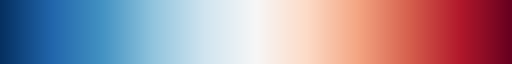

In [174]:
cmap

In [ ]:
#!curl -XGET https://www.metoffice.gov.uk/hadobs/hadcrut5/data/HadCRUT.5.0.2.0/analysis/diagnostics/HadCRUT.5.0.2.0.analysis.summary_series.global.annual.nc